# Real dark current: noise and other artifacts

The dark current on modern CCDs, even relatively inexpensive ones, is very
small. In a typical exposure the dark current is likely smaller, maybe much
smaller, than the read noise. Despite that, it is worth examining some dark
frames from your camera because not all pixels have the same dark current.
Some, called hot pixels, have much higher dark current than the rest of the
sensor. Some sensors have non-astronomical sources of counts whose value are
proportional to exposure time, like dark current, but whose origin is nonthermal
effects.

As we did in the [notebook about overscan](01-08-Overscan.ipynb), we will focus on a pair of
cameras to illustrate this point and demonstrate how to take similar images with
your camera and analyze them.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from astropy.nddata import CCDData
from astropy.visualization import hist

from convenience_functions import show_image

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

## Making an image to check for hot pixels

Measuring the dark current in a camera requires taking images with fairly long
exposure time, ideally long enough that the expected counts due to dark current
is larger than the expected noise in the image. If that isn't the case then the
dark images will be measuring noise, not dark current, as we saw in the
[previous section](03-01-Dark-current-The-ideal-case.ipynb).

There are two ways to ensure that you are measuring dark current:

+ Take some long-exposure dark frames. The exposure time should be long enough
that the expected dark counts is at least as large as the noise expected in a
single image.
+ Take several of these images and combine them to reduce the noise in the
result. The noise in the combined image is proportional to $1/\sqrt{N}$, where
$N$ is the number of images that are combined.


### What if that isn't possible?

Do your best. The darks from the Large Format Camera were taken as part of a
science run in which there was limited time for taking dark frames. The key
thing to keep in mind is the lower limit on the dark current you can measure,
given the read noise and exposure time.

The darks in Case 2 were taken with a new camera that was not yet mounted on the
telescope as part of commissioning the camera. That made taking over five hours of
dark frames more feasible!

## Case 1: Cryogenically cooled  Large Format Camera (LFC) at Palomar

The images in this section are from chip 0 of the LFC at the Palomar 200-inch
telescope. Technical information about the camera is
[here](http://www.astro.caltech.edu/palomar/observer/200inchResources/lfcspecs.html). The technical information says nothing about
the expected dark current of this camera. The expectation for cameras cooled by
liquid nitrogen is that their dark current is essentially zero.

What we will see with this camera is that

+ not all of the pixels have negligible dark current, and
+ not all of the counts in a dark image are from dark current.



### Estimating exposure time and number of frames for measuring dark current

Unfortunately, the technical information for this camera does not include any
information about the expected dark current. For thermoelectrically-cooled
cameras the dark current is no more than 0.1 $e^-$/sec/pixel, and for newer
camers is more like 0.01$e^-$/sec/pixel. We will assume the smaller dark current
here.

The read noise for this camera is 11$e^-$/pixel, so the exposure time needed to
just reach the case where the dark counts is equal to the read noise is

$$
t_\text{dark, min} = \frac{11 e^-/\text{pixel}}{0.01 e^-/\text{sec/pixel}} = 1100~\text{sec}.
$$

Even that leaves us with an image dominated by read noise rather than dark
current. Combining 100 of those images would reduce the read noise by a factor
of 10, which would be ideal for precisely measuring the dark current in each
pixel. Unfortunately, taking over 30 hours of dark images is not feasible.

Instead, we will work with what we have for this camera: three dark images, each
300 seconds. This places a lower limit on the dark current we can measure — we
will only be able to measure the dark current for fairly "hot" pixels — but it
at least gives us some idea of the dark properties of the camera.

Another way to phrase this is much more positive: for most of the pixels in the
image the dark current simply does not matter because it is completely swamped
by the read noise.

First, we read in the image.

In [3]:
calibrated_images = Path('.')
combined_dark_lfc = CCDData.read(calibrated_images / 'combined_dark_300.000.fits.bz2')

### Examine the image

The full image is on the left, and the lower left corner is shown on the right.
The light area in the lower left corner is due to sensor glow, which is light
emitted by the electronics of the CCD. The counts in the image due to sensor
glow should grow linearly with exposure time, like dark counts do, but the pixel
values are much higher than for pixels whose counts are due to dark current.

The top right panel in the figure below shows the part of the CCD near the
sensor glow; pixel values are several thousand counts. The bottom right panel
shows a portion of the CCD in the upper right part of the chip; pixel values are
*much* lower, typically under 10.

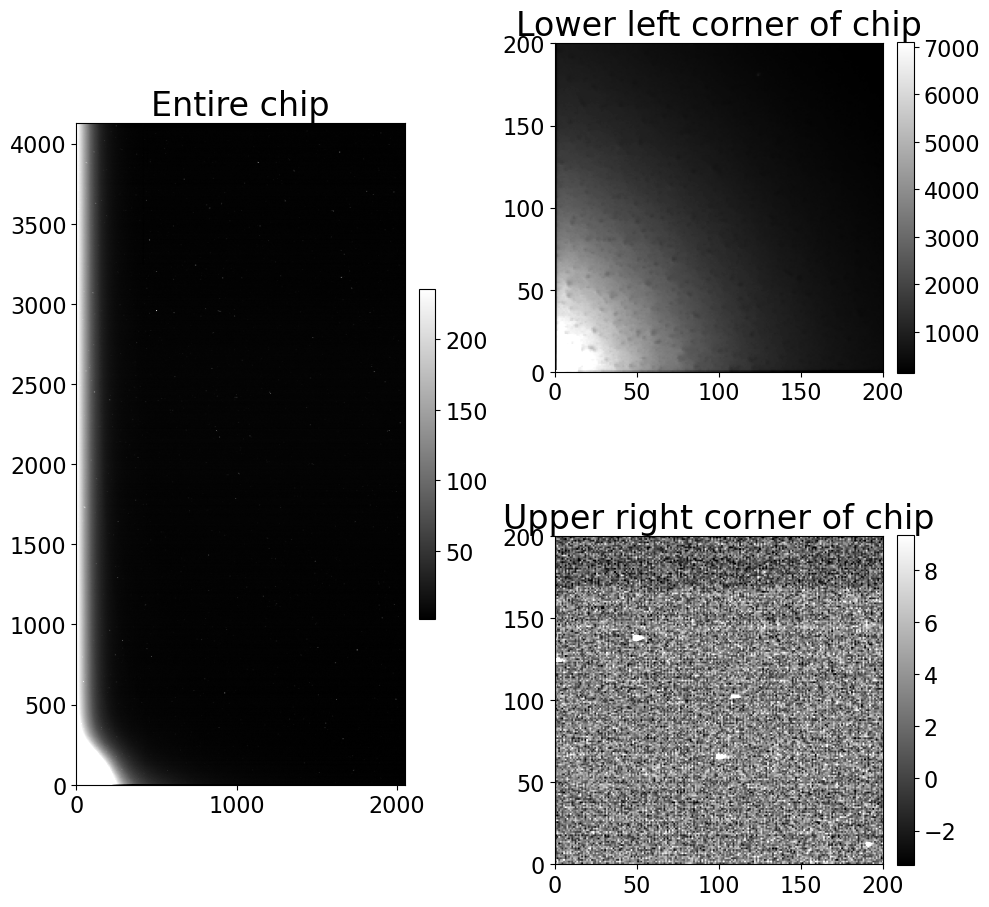

In [4]:
fig = plt.figure(figsize=(10, 10))
whole_im_ax = plt.subplot(121)
glow_ax = plt.subplot(222)
dark_ax = plt.subplot(224)

show_image(combined_dark_lfc, cmap='gray', ax=whole_im_ax, fig=fig)
whole_im_ax.set_title('Entire chip')

show_image(combined_dark_lfc[:200, :200], cmap='gray', ax=glow_ax, fig=fig)
glow_ax.set_title('Lower left corner of chip')

show_image(combined_dark_lfc[-200:, -200:], cmap='gray', ax=dark_ax, fig=fig)
dark_ax.set_title('Upper right corner of chip')

plt.tight_layout()

### Dark current in this CCD

The histogram below shows dark current along the horizontal axis and the number
of pixels in the CCD with that dark current along the vertical axis. Since there
is obvious sensor glow in the darks, three distributions are shown:

+ The full sensor, which at first glance has some pixels with dark current as
high as 10 $e^-$/sec.
+ The portion of the sensor *excluding* the sensor glow, in which the dark
current is, as expected, low, though there is a small fraction of "hot pixels"
with dark current around 1 $e^-$/sec.
+ The sensor glow region. That region is apparent in the clump of pixels with
equivalent dark current of 0.5$e^-$/sec and higher.



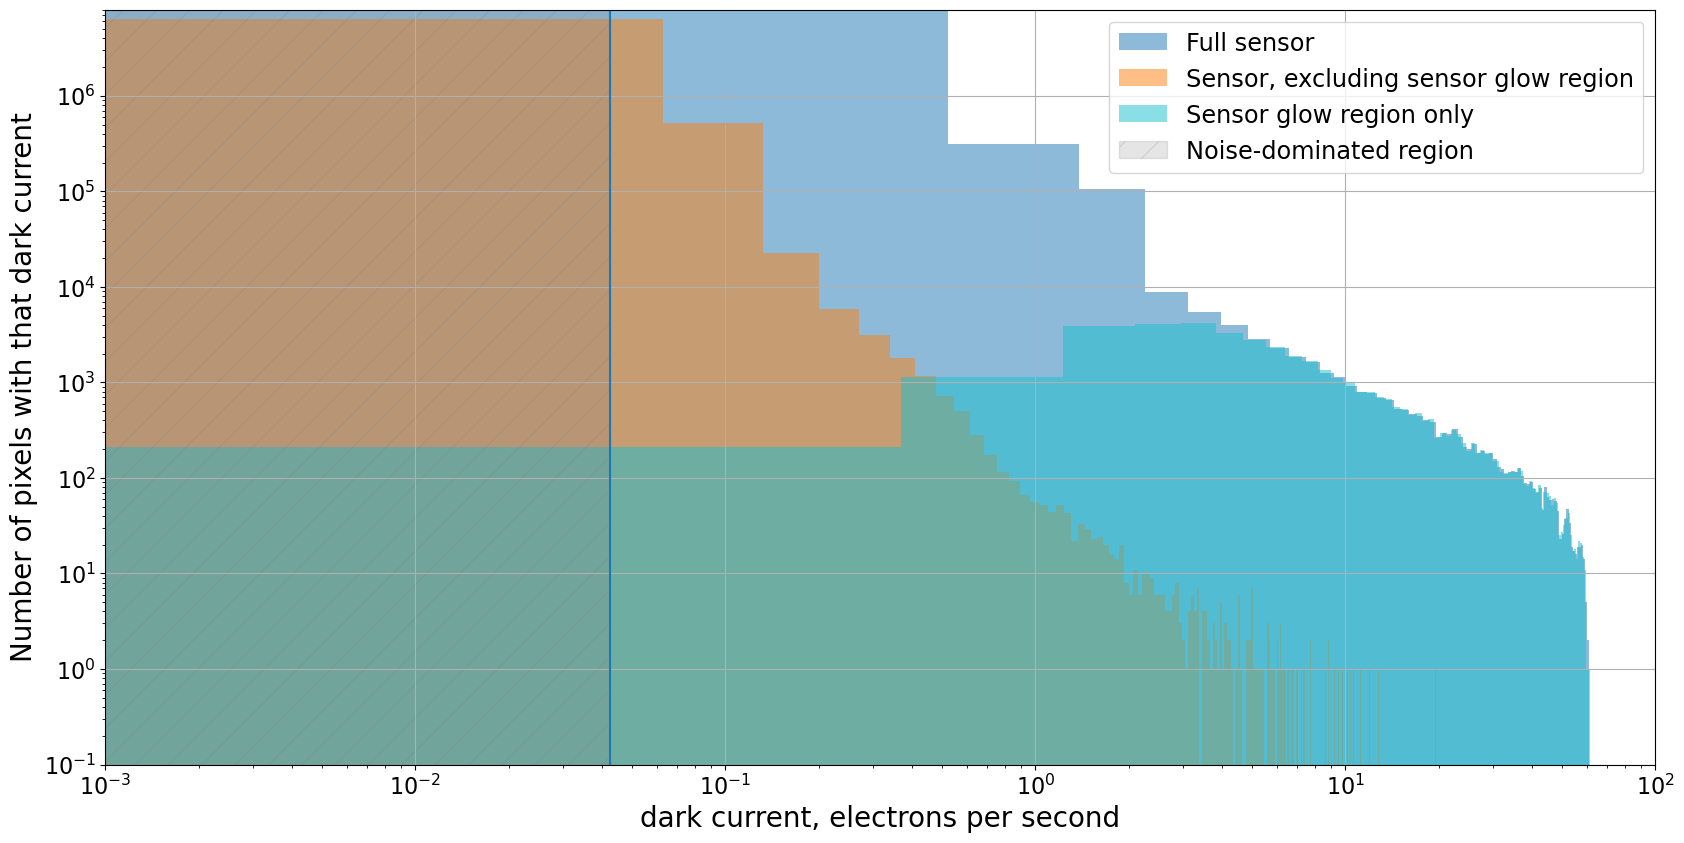

In [5]:
gain = 2.0
exposure_time = 300
dark_current_ln2 = gain * combined_dark_lfc.data / exposure_time

fig = plt.figure(figsize=(20, 10))
hist(dark_current_ln2.flatten(), bins=500, density=False, alpha=0.5, color='C0',
     label='Full sensor');
hist(dark_current_ln2[200:, 200:].flatten(), bins=500, density=False, alpha=0.5, color='C1',
     label='Sensor, excluding sensor glow region')
hist(dark_current_ln2[:200, :200].flatten(), bins=500, density=False, alpha=0.5, color='C9',
     label='Sensor glow region only');
#plt.semilogy()
plt.loglog()

plt.grid()
noise_limit = 2 * 11/exposure_time/np.sqrt(3)
plt.vlines(2 * 11/exposure_time/np.sqrt(3), 0.1, 8e6)
plt.ylim(0.1, 8e6)
plt.xlim(1e-3, 1e2)
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
noisy_region = plt.Rectangle((x_min, y_min), noise_limit - x_min, y_max - y_min, label='Noise-dominated region',
                             color='gray', alpha=0.2, hatch='/')
ax = plt.gca()
ax.add_patch(noisy_region)
plt.legend()
plt.xlabel('dark current, electrons per second')
plt.ylabel('Number of pixels with that dark current');


## Case 2: Thermoelectrically-cooled camera

### Taking an image to measure dark current

The image below is a combination of 20 dark frames, each a 1000 sec exposure.
That exposure time was chosen so that the expected number of dark electrons was
at least somewhat larger than the read noise expected in a combination of 20
images. As we saw in the previous notebook, unless that is the case the dark
frames will measure read noise instead of dark current.

This camera has a dark current of $0.01 e^-$/sec/pixel and read noise of roughly
$10 e^-$/read/pixel/, so the exposure time at which the dark current is as large
as the read noise is

$$
t_\text{dark, min} = \frac{10 e^-/\text{pixel}}{0.01 e^-/\text{sec/pixel}} = 1000~\text{sec}.
$$

By combining 20 of the images, the expected noise in the combination is reduced
by a factor of $\sqrt{20}$ to $2.2 e^-$/pixel. This puts us in the "low read
noise" limit in the previous notebook about ideal dark current.

Measuring the dark current once you have the images is relatively
direct: subtract the bias, multiply the result by the gain, and then
divide by the exposure time to obtain the dark current in $e^-$/pixel/sec.

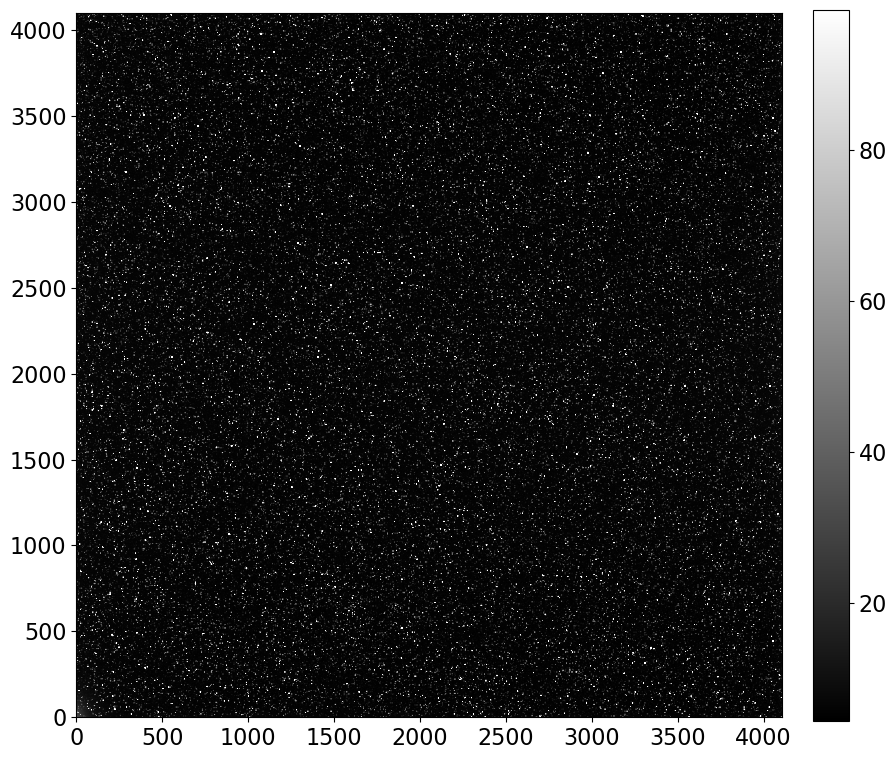

In [6]:
dark_1000 = CCDData.read('combined_dark_exposure_1000.0.fit.bz2')
show_image(dark_1000, cmap='gray')

### Calculate the dark current for each pixel

Recall that the dark current $d_c(T)$ is given by

$$
d_c(T) = d_e(t) / t,
$$

where $d_e(t)$ is the number of dark electrons in the images. That is related to
the dark counts, $n_{dark}(t)$, the image values displayed in the image above,
by the gain of the camera, $d_e(t) = g n_{dark}(t)$, so that

$$
d_C(T) = g n_{dark}(t) / t.
$$

This particular camera has a gain of $g = 1.5 e^-$/ADU.

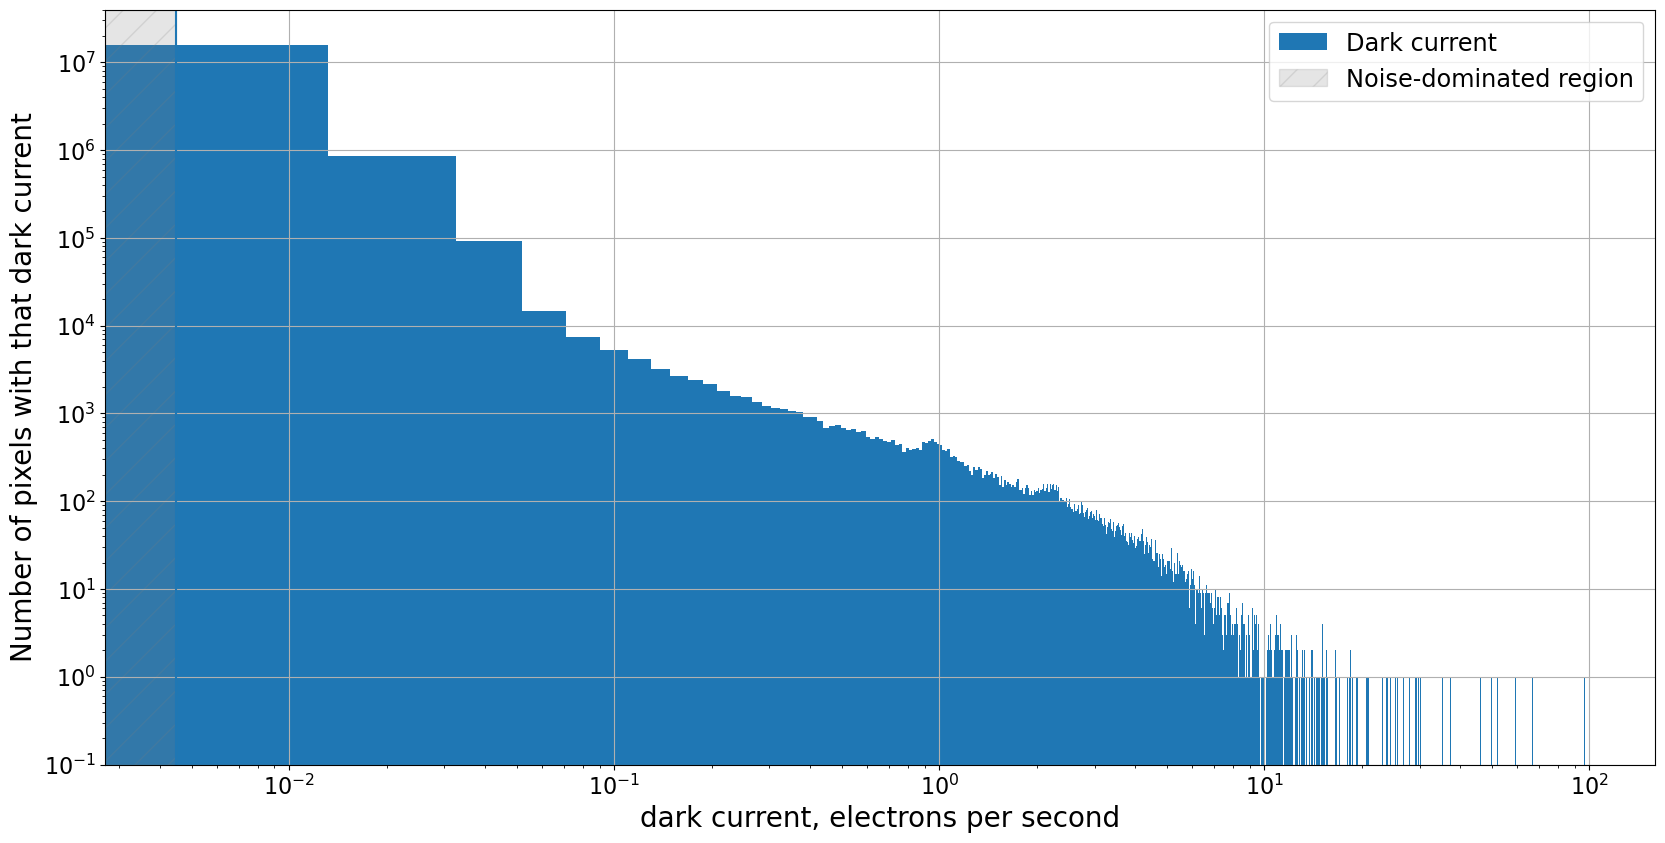

In [7]:
gain = 1.5
read_noise = 10.0
exposure_time = 1000

dark_current = gain * dark_1000.data / exposure_time

noisy_region = 2 * read_noise / exposure_time / np.sqrt(20)

plt.figure(figsize=(20, 10))
hist(dark_current.flatten(), bins=5000, density=False, label='Dark current');

plt.ylim(0.1, 4e7)
plt.vlines(noisy_region, *plt.ylim())

plt.loglog()
plt.grid()


x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
noisy_region = plt.Rectangle((x_min, y_min), noisy_region - x_min, y_max - y_min, label='Noise-dominated region',
                             color='gray', alpha=0.2, hatch='/')
ax = plt.gca()
ax.add_patch(noisy_region)

plt.legend()

plt.xlabel('dark current, electrons per second')
plt.ylabel('Number of pixels with that dark current');


### There is a large range in the dark current

While the vast majority of the pixels do, as expected, have very low dark
current, it is much higher for other pixels. These pixels, called hot pixels,
can occur even in cryogenically-cooled cameras.

The vast majority of the pixels in the image have a dark current around the
value promised by the manufacturer, 0.01 $e^-$/sec; the highest nominally have a
dark current of 98 $e^-$/sec.

However, there is  an upper limit to the dark current that can be measured in a
particular exposure because the CCD saturates once the counts become large
enough. In other words, there is an upper limit to the number of counts a CCD
can represent; for this camera the limit is $2^{16} -1$, or $65,563$ counts. If
we convert that to a dark current for a 1000 sec exposure, it is approximately

$$
\text{dark current for saturated pixel} =  \text{gain} \times \frac{\text{saturation counts}}{\text{exposure time}} =  1.5 \frac{e^-}{\text{count}}\frac{65,563~\text{count}}{1000 \text{sec}} = 98 \frac{e^-}{\text{sec}}.
$$

For the hottest pixels in this image, that is the *lower limit* of the dark
current for those pixels.

The dark current is also not well estimated for pixels a bit below the maximum
because CCDs stop responding linearly once they pass a pixel value that depends
on the camera. For this camera, the linearity limit is around 55,000 counts,
corresponding to a dark current of roughly  82 $e^-$/sec.

You can, in principle, also check whether or not the hot pixels have a constant dark
current that does not change with time by creating a number of these darks at
different exposure times and plotting the dark current as a function of exposure
time for the hot pixels. If the dark current is constant then the dark counts
will be properly removed when the dark is subtracted from the science image. If
the dark current is not constant, the pixel should be excluded from analysis.

The fraction of very hot pixels, those above 1 $e^-$/sec, is relatively small,
roughly 0.1% of the pixels.

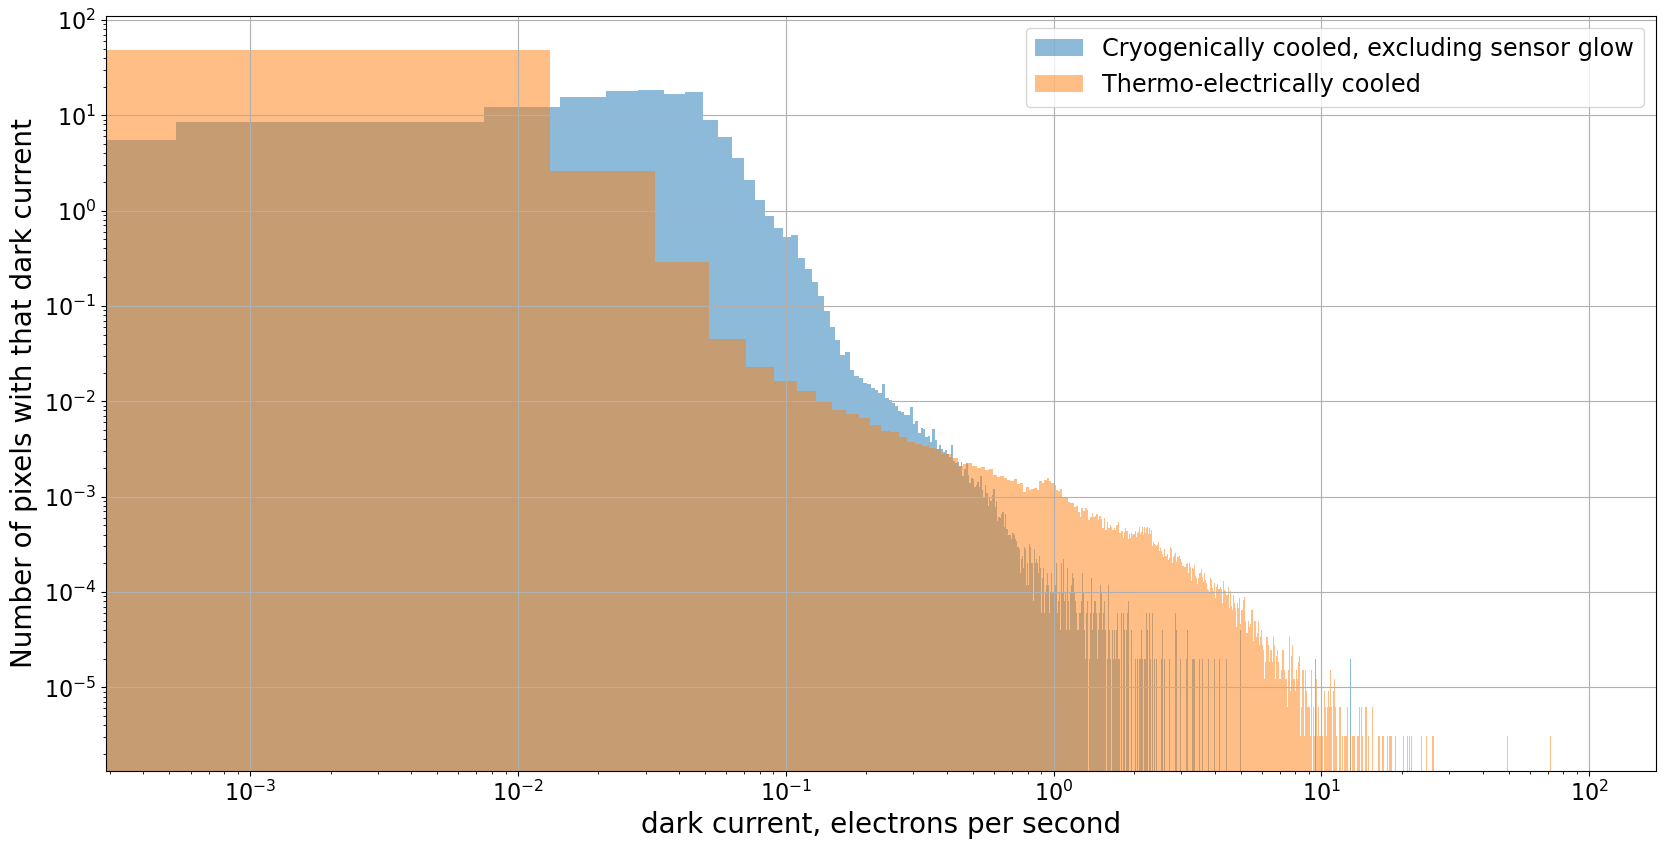

In [8]:
plt.figure(figsize=(20, 10))
hist(dark_current_ln2[200:, 200:].flatten(), bins=5000, density=True, alpha=0.5, label='Cryogenically cooled, excluding sensor glow');
hist(dark_current.flatten(), bins=5000, density=True, alpha=0.5, label='Thermo-electrically cooled');
plt.grid()
plt.loglog()
plt.xlabel('dark current, electrons per second')
plt.ylabel('Number of pixels with that dark current');
plt.legend();

## How to handle hot pixels

There are a few ways you could handle this, which can be used in combination
with each other:

+ Mark all pixels above some threshold as bad and create a mask to keep track of
these bad pixels.
+ Mark only the really high dark current pixels as bad and mask them; for the
rest, subtract dark current as usual.
+ Always take dark images with exposure times that match your flat and light
frames and subtract dark current as usual.
+ Take one set of darks with exposure equal to the *longest* exposure time in
your flat and light images and scale the dark current downwards to match your
other exposure times.

## One thing NOT to do

Do not take short dark frames and scale them up to longer exposure times. Modern
cameras, even thermoelectrically-cooled ones, have very low dark current. If
your dark frames have low exposure time then most of the pixels are measuring
read noise, not dark current. If you rescale those images to a longer exposure
time then you inappropriately amplify that noise. Ideally, the expected dark
counts (or dark electrons) in your dark frames should be at least a few times
larger than the expected read noise in the frames you combine to make a
reference dark.

## Summary

1. A dark frame only measures dark current if the expected dark counts exceed
the read noise of the camera by a factor of a few.
2. Take multiple dark frames and combine them to reduce the noise level in the
combined image as much as possible.
2. Most pixels in a CCD have very low dark current.
3. A consequence of 1 and 3 is that you should almost never scale your dark
frames up to a longer exposure time because you will amplify noise instead of
eliminating dark current, even if you have combined multiple images as in 2.
3. Identify hot pixels and mask them out or otherwise deal with them.